In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_23.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,23,0.333,2.24,-20
1,23,0.333,2.24,-20
2,23,0.332,2.24,-20
3,23,0.333,2.24,-20
4,23,0.333,2.24,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


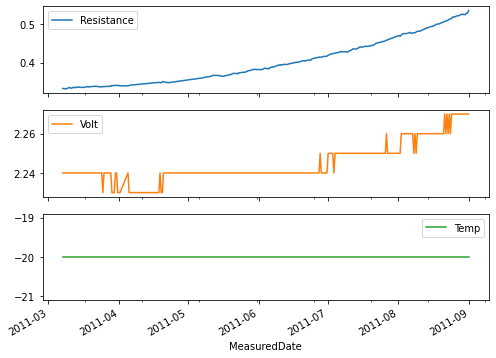

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

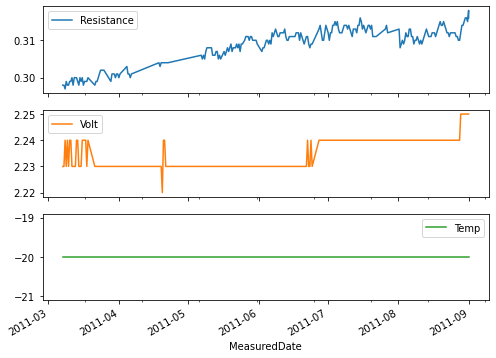

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,251.0,23.000000,0.000000,23.000,23.000,23.000,23.000,23.000
Resistance,251.0,0.411199,0.058896,0.332,0.365,0.401,0.453,0.535
Volt,251.0,2.246653,0.010429,2.230,2.240,2.240,2.250,2.270
Temp,251.0,-20.000000,0.000000,-20.000,-20.000,-20.000,-20.000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.004926,0.25,0.0
1,0.004926,0.25,0.0
2,0.000000,0.25,0.0
3,0.004926,0.25,0.0
4,0.004926,0.25,0.0


<AxesSubplot:>

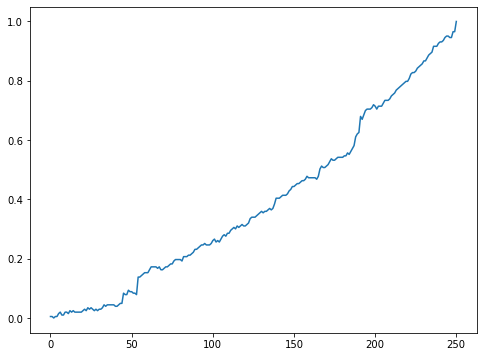

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

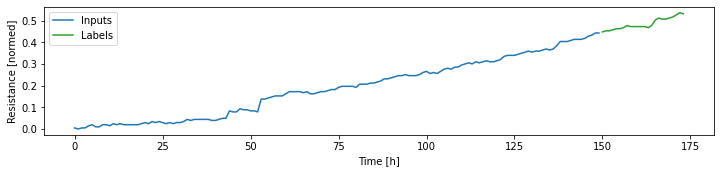

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 0.1589 - mean_absolute_error: 0.3244
Epoch 2/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.1567 - mean_absolute_error: 0.3221
Epoch 3/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.1543 - mean_absolute_error: 0.3197
Epoch 4/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.1518 - mean_absolute_error: 0.3170
Epoch 5/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.1491 - mean_absolute_error: 0.3141
Epoch 6/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.1461 - mean_absolute_error: 0.3109
Epoch 7/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.1428 - mean_absolute_error: 0.3074
Epoch 8/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.1393 - mean_absolute_error: 0.3035
Epoch 9/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.1353 - mean_absolute_error: 0.2992
Epoch

Epoch 34/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0080 - mean_absolute_error: 0.0711
Epoch 35/1500
1/1 [==============================] - 0s 96ms/step - loss: 0.0078 - mean_absolute_error: 0.0705
Epoch 36/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0071 - mean_absolute_error: 0.0677
Epoch 37/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0062 - mean_absolute_error: 0.0633
Epoch 38/1500
1/1 [==============================] - 0s 100ms/step - loss: 0.0051 - mean_absolute_error: 0.0575
Epoch 39/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0040 - mean_absolute_error: 0.0507
Epoch 40/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0030 - mean_absolute_error: 0.0433
Epoch 41/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0021 - mean_absolute_error: 0.0356
Epoch 42/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0014 - mean_absolute_error: 0.02

Epoch 67/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.8534e-04 - mean_absolute_error: 0.0081
Epoch 68/1500
1/1 [==============================] - 0s 94ms/step - loss: 5.1609e-04 - mean_absolute_error: 0.0097
Epoch 69/1500
1/1 [==============================] - 0s 96ms/step - loss: 5.4601e-04 - mean_absolute_error: 0.0109
Epoch 70/1500
1/1 [==============================] - 0s 96ms/step - loss: 5.7037e-04 - mean_absolute_error: 0.0119
Epoch 71/1500
1/1 [==============================] - 0s 104ms/step - loss: 5.8600e-04 - mean_absolute_error: 0.0125
Epoch 72/1500
1/1 [==============================] - 0s 102ms/step - loss: 5.9141e-04 - mean_absolute_error: 0.0127
Epoch 73/1500
1/1 [==============================] - 0s 100ms/step - loss: 5.8673e-04 - mean_absolute_error: 0.0126
Epoch 74/1500
1/1 [==============================] - 0s 99ms/step - loss: 5.7338e-04 - mean_absolute_error: 0.0122
Epoch 75/1500
1/1 [==============================] - 0s 101ms/step - loss: 5.

Epoch 99/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3868e-04 - mean_absolute_error: 0.0045
Epoch 100/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3872e-04 - mean_absolute_error: 0.0045
Epoch 101/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3934e-04 - mean_absolute_error: 0.0047
Epoch 102/1500
1/1 [==============================] - 0s 91ms/step - loss: 4.4029e-04 - mean_absolute_error: 0.0049
Epoch 103/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.4132e-04 - mean_absolute_error: 0.0051
Epoch 104/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.4223e-04 - mean_absolute_error: 0.0052
Epoch 105/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.4286e-04 - mean_absolute_error: 0.0053
Epoch 106/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.4314e-04 - mean_absolute_error: 0.0054
Epoch 107/1500
1/1 [==============================] - 0s 94ms/step - loss

1/1 [==============================] - 0s 104ms/step - loss: 4.3852e-04 - mean_absolute_error: 0.0044
Epoch 132/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3853e-04 - mean_absolute_error: 0.0044
Epoch 133/1500
1/1 [==============================] - 0s 110ms/step - loss: 4.3856e-04 - mean_absolute_error: 0.0045
Epoch 134/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3860e-04 - mean_absolute_error: 0.0045
Epoch 135/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3864e-04 - mean_absolute_error: 0.0045
Epoch 136/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3868e-04 - mean_absolute_error: 0.0045
Epoch 137/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3869e-04 - mean_absolute_error: 0.0045
Epoch 138/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3869e-04 - mean_absolute_error: 0.0045
Epoch 139/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.38

1/1 [==============================] - 0s 102ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 164/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 165/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 166/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 167/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 168/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 169/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 170/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.3850e-04 - mean_absolute_error: 0.0044
Epoch 171/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3849e-0

1/1 [==============================] - 0s 94ms/step - loss: 4.3848e-04 - mean_absolute_error: 0.0044
Epoch 196/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3848e-04 - mean_absolute_error: 0.0044
Epoch 197/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3847e-04 - mean_absolute_error: 0.0044
Epoch 198/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3847e-04 - mean_absolute_error: 0.0044
Epoch 199/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3847e-04 - mean_absolute_error: 0.0044
Epoch 200/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3847e-04 - mean_absolute_error: 0.0044
Epoch 201/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3847e-04 - mean_absolute_error: 0.0044
Epoch 202/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3847e-04 - mean_absolute_error: 0.0044
Epoch 203/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3847e-04 -

1/1 [==============================] - 0s 104ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 228/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 229/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 230/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 231/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 232/1500
1/1 [==============================] - 0s 114ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 233/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 234/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3845e-04 - mean_absolute_error: 0.0044
Epoch 235/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3

1/1 [==============================] - 0s 108ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 260/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 261/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 262/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 263/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 264/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 265/1500
1/1 [==============================] - 0s 110ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 266/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3843e-04 - mean_absolute_error: 0.0044
Epoch 267/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3843e

1/1 [==============================] - 0s 104ms/step - loss: 4.3841e-04 - mean_absolute_error: 0.0044
Epoch 292/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3841e-04 - mean_absolute_error: 0.0044
Epoch 293/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3840e-04 - mean_absolute_error: 0.0044
Epoch 294/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3840e-04 - mean_absolute_error: 0.0044
Epoch 295/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3840e-04 - mean_absolute_error: 0.0044
Epoch 296/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3840e-04 - mean_absolute_error: 0.0044
Epoch 297/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3840e-04 - mean_absolute_error: 0.0044
Epoch 298/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3840e-04 - mean_absolute_error: 0.0044
Epoch 299/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3840e-0

1/1 [==============================] - 0s 98ms/step - loss: 4.3838e-04 - mean_absolute_error: 0.0044
Epoch 324/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3838e-04 - mean_absolute_error: 0.0044
Epoch 325/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3838e-04 - mean_absolute_error: 0.0044
Epoch 326/1500
1/1 [==============================] - 0s 110ms/step - loss: 4.3838e-04 - mean_absolute_error: 0.0044
Epoch 327/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3838e-04 - mean_absolute_error: 0.0044
Epoch 328/1500
1/1 [==============================] - 0s 126ms/step - loss: 4.3838e-04 - mean_absolute_error: 0.0044
Epoch 329/1500
1/1 [==============================] - 0s 185ms/step - loss: 4.3837e-04 - mean_absolute_error: 0.0044
Epoch 330/1500
1/1 [==============================] - 0s 114ms/step - loss: 4.3837e-04 - mean_absolute_error: 0.0044
Epoch 331/1500
1/1 [==============================] - 0s 165ms/step - loss: 4.3837e

1/1 [==============================] - 0s 96ms/step - loss: 4.3835e-04 - mean_absolute_error: 0.0044
Epoch 356/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3835e-04 - mean_absolute_error: 0.0044
Epoch 357/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3835e-04 - mean_absolute_error: 0.0044
Epoch 358/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3835e-04 - mean_absolute_error: 0.0044
Epoch 359/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3835e-04 - mean_absolute_error: 0.0044
Epoch 360/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3835e-04 - mean_absolute_error: 0.0044
Epoch 361/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3835e-04 - mean_absolute_error: 0.0044
Epoch 362/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3834e-04 - mean_absolute_error: 0.0044
Epoch 363/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3834e-

1/1 [==============================] - 0s 98ms/step - loss: 4.3832e-04 - mean_absolute_error: 0.0044
Epoch 388/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3832e-04 - mean_absolute_error: 0.0044
Epoch 389/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3832e-04 - mean_absolute_error: 0.0044
Epoch 390/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3832e-04 - mean_absolute_error: 0.0044
Epoch 391/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3832e-04 - mean_absolute_error: 0.0044
Epoch 392/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3832e-04 - mean_absolute_error: 0.0044
Epoch 393/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3832e-04 - mean_absolute_error: 0.0044
Epoch 394/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3831e-04 - mean_absolute_error: 0.0044
Epoch 395/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3831e-04

1/1 [==============================] - 0s 105ms/step - loss: 4.3829e-04 - mean_absolute_error: 0.0044
Epoch 420/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3829e-04 - mean_absolute_error: 0.0044
Epoch 421/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3829e-04 - mean_absolute_error: 0.0044
Epoch 422/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3829e-04 - mean_absolute_error: 0.0044
Epoch 423/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3828e-04 - mean_absolute_error: 0.0044
Epoch 424/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3828e-04 - mean_absolute_error: 0.0044
Epoch 425/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3828e-04 - mean_absolute_error: 0.0044
Epoch 426/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3828e-04 - mean_absolute_error: 0.0044
Epoch 427/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3828e

1/1 [==============================] - 0s 99ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 452/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 453/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 454/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 455/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 456/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 457/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 458/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3825e-04 - mean_absolute_error: 0.0044
Epoch 459/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3825e-0

1/1 [==============================] - 0s 104ms/step - loss: 4.3822e-04 - mean_absolute_error: 0.0044
Epoch 484/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3822e-04 - mean_absolute_error: 0.0044
Epoch 485/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3822e-04 - mean_absolute_error: 0.0044
Epoch 486/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3822e-04 - mean_absolute_error: 0.0044
Epoch 487/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3821e-04 - mean_absolute_error: 0.0044
Epoch 488/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3821e-04 - mean_absolute_error: 0.0044
Epoch 489/1500
1/1 [==============================] - ETA: 0s - loss: 4.3821e-04 - mean_absolute_error: 0.004 - 0s 99ms/step - loss: 4.3821e-04 - mean_absolute_error: 0.0044
Epoch 490/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3821e-04 - mean_absolute_error: 0.0044
Epoch 491/1500
1/1 [=====

Epoch 515/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3818e-04 - mean_absolute_error: 0.0044
Epoch 516/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3818e-04 - mean_absolute_error: 0.0044
Epoch 517/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3818e-04 - mean_absolute_error: 0.0044
Epoch 518/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3818e-04 - mean_absolute_error: 0.0044
Epoch 519/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3818e-04 - mean_absolute_error: 0.0044
Epoch 520/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3817e-04 - mean_absolute_error: 0.0044
Epoch 521/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3817e-04 - mean_absolute_error: 0.0044
Epoch 522/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3817e-04 - mean_absolute_error: 0.0044
Epoch 523/1500
1/1 [==============================] - 0s 98ms/step 

1/1 [==============================] - 0s 97ms/step - loss: 4.3814e-04 - mean_absolute_error: 0.0044
Epoch 548/1500
1/1 [==============================] - 0s 92ms/step - loss: 4.3814e-04 - mean_absolute_error: 0.0044
Epoch 549/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3814e-04 - mean_absolute_error: 0.0044
Epoch 550/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3814e-04 - mean_absolute_error: 0.0044
Epoch 551/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3814e-04 - mean_absolute_error: 0.0044
Epoch 552/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3813e-04 - mean_absolute_error: 0.0044
Epoch 553/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3813e-04 - mean_absolute_error: 0.0044
Epoch 554/1500
1/1 [==============================] - 0s 93ms/step - loss: 4.3813e-04 - mean_absolute_error: 0.0044
Epoch 555/1500
1/1 [==============================] - 0s 93ms/step - loss: 4.3813e-04 

1/1 [==============================] - 0s 105ms/step - loss: 4.3810e-04 - mean_absolute_error: 0.0044
Epoch 580/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3810e-04 - mean_absolute_error: 0.0044
Epoch 581/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3810e-04 - mean_absolute_error: 0.0044
Epoch 582/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3809e-04 - mean_absolute_error: 0.0044
Epoch 583/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3809e-04 - mean_absolute_error: 0.0044
Epoch 584/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3809e-04 - mean_absolute_error: 0.0044
Epoch 585/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3809e-04 - mean_absolute_error: 0.0044
Epoch 586/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3809e-04 - mean_absolute_error: 0.0044
Epoch 587/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3809

1/1 [==============================] - 0s 107ms/step - loss: 4.3805e-04 - mean_absolute_error: 0.0044
Epoch 612/1500
1/1 [==============================] - 0s 115ms/step - loss: 4.3805e-04 - mean_absolute_error: 0.0044
Epoch 613/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3805e-04 - mean_absolute_error: 0.0044
Epoch 614/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3805e-04 - mean_absolute_error: 0.0044
Epoch 615/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3805e-04 - mean_absolute_error: 0.0044
Epoch 616/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3805e-04 - mean_absolute_error: 0.0044
Epoch 617/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3804e-04 - mean_absolute_error: 0.0044
Epoch 618/1500
1/1 [==============================] - 0s 112ms/step - loss: 4.3804e-04 - mean_absolute_error: 0.0044
Epoch 619/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.38

1/1 [==============================] - 0s 97ms/step - loss: 4.3801e-04 - mean_absolute_error: 0.0044
Epoch 644/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3800e-04 - mean_absolute_error: 0.0044
Epoch 645/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3800e-04 - mean_absolute_error: 0.0044
Epoch 646/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3800e-04 - mean_absolute_error: 0.0044
Epoch 647/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3800e-04 - mean_absolute_error: 0.0044
Epoch 648/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3800e-04 - mean_absolute_error: 0.0044
Epoch 649/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3800e-04 - mean_absolute_error: 0.0044
Epoch 650/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3800e-04 - mean_absolute_error: 0.0044
Epoch 651/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3799e

1/1 [==============================] - 0s 99ms/step - loss: 4.3796e-04 - mean_absolute_error: 0.0044
Epoch 676/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3795e-04 - mean_absolute_error: 0.0044
Epoch 677/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3795e-04 - mean_absolute_error: 0.0044
Epoch 678/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3795e-04 - mean_absolute_error: 0.0044
Epoch 679/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3795e-04 - mean_absolute_error: 0.0044
Epoch 680/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3795e-04 - mean_absolute_error: 0.0044
Epoch 681/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3795e-04 - mean_absolute_error: 0.0044
Epoch 682/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3794e-04 - mean_absolute_error: 0.0044
Epoch 683/1500
1/1 [==============================] - 0s 92ms/step - loss: 4.3794e-04 

1/1 [==============================] - 0s 96ms/step - loss: 4.3790e-04 - mean_absolute_error: 0.0044
Epoch 708/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3790e-04 - mean_absolute_error: 0.0044
Epoch 709/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3790e-04 - mean_absolute_error: 0.0044
Epoch 710/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3790e-04 - mean_absolute_error: 0.0044
Epoch 711/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3790e-04 - mean_absolute_error: 0.0044
Epoch 712/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3789e-04 - mean_absolute_error: 0.0044
Epoch 713/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3789e-04 - mean_absolute_error: 0.0044
Epoch 714/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3789e-04 - mean_absolute_error: 0.0044
Epoch 715/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3789e

1/1 [==============================] - 0s 101ms/step - loss: 4.3785e-04 - mean_absolute_error: 0.0044
Epoch 740/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3784e-04 - mean_absolute_error: 0.0044
Epoch 741/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3784e-04 - mean_absolute_error: 0.0044
Epoch 742/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3784e-04 - mean_absolute_error: 0.0044
Epoch 743/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3784e-04 - mean_absolute_error: 0.0044
Epoch 744/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3784e-04 - mean_absolute_error: 0.0044
Epoch 745/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3783e-04 - mean_absolute_error: 0.0044
Epoch 746/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3783e-04 - mean_absolute_error: 0.0044
Epoch 747/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3783e-

1/1 [==============================] - 0s 99ms/step - loss: 4.3779e-04 - mean_absolute_error: 0.0044
Epoch 772/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3778e-04 - mean_absolute_error: 0.0044
Epoch 773/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3778e-04 - mean_absolute_error: 0.0044
Epoch 774/1500
1/1 [==============================] - 0s 109ms/step - loss: 4.3778e-04 - mean_absolute_error: 0.0044
Epoch 775/1500
1/1 [==============================] - 0s 109ms/step - loss: 4.3778e-04 - mean_absolute_error: 0.0044
Epoch 776/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.3778e-04 - mean_absolute_error: 0.0044
Epoch 777/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3777e-04 - mean_absolute_error: 0.0044
Epoch 778/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3777e-04 - mean_absolute_error: 0.0044
Epoch 779/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3777e

1/1 [==============================] - 0s 152ms/step - loss: 4.3772e-04 - mean_absolute_error: 0.0044
Epoch 804/1500
1/1 [==============================] - 0s 111ms/step - loss: 4.3772e-04 - mean_absolute_error: 0.0044
Epoch 805/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3772e-04 - mean_absolute_error: 0.0044
Epoch 806/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3771e-04 - mean_absolute_error: 0.0044
Epoch 807/1500
1/1 [==============================] - 0s 93ms/step - loss: 4.3771e-04 - mean_absolute_error: 0.0044
Epoch 808/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3771e-04 - mean_absolute_error: 0.0044
Epoch 809/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3771e-04 - mean_absolute_error: 0.0044
Epoch 810/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.3771e-04 - mean_absolute_error: 0.0044
Epoch 811/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3770

1/1 [==============================] - 0s 98ms/step - loss: 4.3765e-04 - mean_absolute_error: 0.0044
Epoch 836/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3765e-04 - mean_absolute_error: 0.0044
Epoch 837/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3765e-04 - mean_absolute_error: 0.0044
Epoch 838/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3764e-04 - mean_absolute_error: 0.0044
Epoch 839/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3764e-04 - mean_absolute_error: 0.0044
Epoch 840/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3764e-04 - mean_absolute_error: 0.0044
Epoch 841/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3764e-04 - mean_absolute_error: 0.0044
Epoch 842/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3763e-04 - mean_absolute_error: 0.0044
Epoch 843/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3763

1/1 [==============================] - 0s 105ms/step - loss: 4.3758e-04 - mean_absolute_error: 0.0044
Epoch 868/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3757e-04 - mean_absolute_error: 0.0044
Epoch 869/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3757e-04 - mean_absolute_error: 0.0044
Epoch 870/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3757e-04 - mean_absolute_error: 0.0044
Epoch 871/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3757e-04 - mean_absolute_error: 0.0044
Epoch 872/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3756e-04 - mean_absolute_error: 0.0044
Epoch 873/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3756e-04 - mean_absolute_error: 0.0044
Epoch 874/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3756e-04 - mean_absolute_error: 0.0044
Epoch 875/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3756e-

1/1 [==============================] - 0s 101ms/step - loss: 4.3750e-04 - mean_absolute_error: 0.0044
Epoch 900/1500
1/1 [==============================] - 0s 141ms/step - loss: 4.3749e-04 - mean_absolute_error: 0.0044
Epoch 901/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3749e-04 - mean_absolute_error: 0.0044
Epoch 902/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3749e-04 - mean_absolute_error: 0.0044
Epoch 903/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3748e-04 - mean_absolute_error: 0.0044
Epoch 904/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3748e-04 - mean_absolute_error: 0.0044
Epoch 905/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3748e-04 - mean_absolute_error: 0.0044
Epoch 906/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3748e-04 - mean_absolute_error: 0.0044
Epoch 907/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.37

1/1 [==============================] - 0s 98ms/step - loss: 4.3741e-04 - mean_absolute_error: 0.0044
Epoch 932/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3740e-04 - mean_absolute_error: 0.0044
Epoch 933/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3740e-04 - mean_absolute_error: 0.0044
Epoch 934/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3740e-04 - mean_absolute_error: 0.0044
Epoch 935/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3740e-04 - mean_absolute_error: 0.0044
Epoch 936/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3739e-04 - mean_absolute_error: 0.0044
Epoch 937/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3739e-04 - mean_absolute_error: 0.0044
Epoch 938/1500
1/1 [==============================] - 0s 91ms/step - loss: 4.3739e-04 - mean_absolute_error: 0.0044
Epoch 939/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3738e-

1/1 [==============================] - 0s 99ms/step - loss: 4.3731e-04 - mean_absolute_error: 0.0044
Epoch 964/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3731e-04 - mean_absolute_error: 0.0044
Epoch 965/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3731e-04 - mean_absolute_error: 0.0044
Epoch 966/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3730e-04 - mean_absolute_error: 0.0044
Epoch 967/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3730e-04 - mean_absolute_error: 0.0044
Epoch 968/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3730e-04 - mean_absolute_error: 0.0044
Epoch 969/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3729e-04 - mean_absolute_error: 0.0044
Epoch 970/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3729e-04 - mean_absolute_error: 0.0044
Epoch 971/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3729e-04

1/1 [==============================] - 0s 102ms/step - loss: 4.3721e-04 - mean_absolute_error: 0.0044
Epoch 996/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3720e-04 - mean_absolute_error: 0.0044
Epoch 997/1500
1/1 [==============================] - 0s 93ms/step - loss: 4.3720e-04 - mean_absolute_error: 0.0044
Epoch 998/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3720e-04 - mean_absolute_error: 0.0044
Epoch 999/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.3719e-04 - mean_absolute_error: 0.0044
Epoch 1000/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3719e-04 - mean_absolute_error: 0.0044
Epoch 1001/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3719e-04 - mean_absolute_error: 0.0044
Epoch 1002/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3718e-04 - mean_absolute_error: 0.0044
Epoch 1003/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.37

Epoch 1027/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3709e-04 - mean_absolute_error: 0.0044
Epoch 1028/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3709e-04 - mean_absolute_error: 0.0044
Epoch 1029/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3708e-04 - mean_absolute_error: 0.0044
Epoch 1030/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3708e-04 - mean_absolute_error: 0.0044
Epoch 1031/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3708e-04 - mean_absolute_error: 0.0044
Epoch 1032/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3707e-04 - mean_absolute_error: 0.0044
Epoch 1033/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3707e-04 - mean_absolute_error: 0.0044
Epoch 1034/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3707e-04 - mean_absolute_error: 0.0044
Epoch 1035/1500
1/1 [==============================] - 0s 

Epoch 1059/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3696e-04 - mean_absolute_error: 0.0044
Epoch 1060/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3696e-04 - mean_absolute_error: 0.0044
Epoch 1061/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3696e-04 - mean_absolute_error: 0.0044
Epoch 1062/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3695e-04 - mean_absolute_error: 0.0044
Epoch 1063/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3695e-04 - mean_absolute_error: 0.0044
Epoch 1064/1500
1/1 [==============================] - 0s 109ms/step - loss: 4.3694e-04 - mean_absolute_error: 0.0044
Epoch 1065/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3694e-04 - mean_absolute_error: 0.0044
Epoch 1066/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.3694e-04 - mean_absolute_error: 0.0044
Epoch 1067/1500
1/1 [==============================] - 0s 

Epoch 1091/1500
1/1 [==============================] - 0s 111ms/step - loss: 4.3682e-04 - mean_absolute_error: 0.0044
Epoch 1092/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3682e-04 - mean_absolute_error: 0.0044
Epoch 1093/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3681e-04 - mean_absolute_error: 0.0044
Epoch 1094/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3681e-04 - mean_absolute_error: 0.0044
Epoch 1095/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3680e-04 - mean_absolute_error: 0.0044
Epoch 1096/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3680e-04 - mean_absolute_error: 0.0044
Epoch 1097/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3679e-04 - mean_absolute_error: 0.0044
Epoch 1098/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3679e-04 - mean_absolute_error: 0.0044
Epoch 1099/1500
1/1 [==============================] - 0

Epoch 1123/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3666e-04 - mean_absolute_error: 0.0044
Epoch 1124/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3666e-04 - mean_absolute_error: 0.0044
Epoch 1125/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3665e-04 - mean_absolute_error: 0.0044
Epoch 1126/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3665e-04 - mean_absolute_error: 0.0044
Epoch 1127/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3664e-04 - mean_absolute_error: 0.0044
Epoch 1128/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3664e-04 - mean_absolute_error: 0.0044
Epoch 1129/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3663e-04 - mean_absolute_error: 0.0044
Epoch 1130/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3663e-04 - mean_absolute_error: 0.0044
Epoch 1131/1500
1/1 [==============================] - 0s 98ms/

Epoch 1155/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3648e-04 - mean_absolute_error: 0.0044
Epoch 1156/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3648e-04 - mean_absolute_error: 0.0044
Epoch 1157/1500
1/1 [==============================] - 0s 119ms/step - loss: 4.3647e-04 - mean_absolute_error: 0.0044
Epoch 1158/1500
1/1 [==============================] - 0s 109ms/step - loss: 4.3646e-04 - mean_absolute_error: 0.0044
Epoch 1159/1500
1/1 [==============================] - 0s 113ms/step - loss: 4.3646e-04 - mean_absolute_error: 0.0044
Epoch 1160/1500
1/1 [==============================] - 0s 114ms/step - loss: 4.3645e-04 - mean_absolute_error: 0.0044
Epoch 1161/1500
1/1 [==============================] - 0s 109ms/step - loss: 4.3644e-04 - mean_absolute_error: 0.0044
Epoch 1162/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3644e-04 - mean_absolute_error: 0.0044
Epoch 1163/1500
1/1 [==============================] - 0s

Epoch 1187/1500
1/1 [==============================] - 0s 122ms/step - loss: 4.3627e-04 - mean_absolute_error: 0.0044
Epoch 1188/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3627e-04 - mean_absolute_error: 0.0044
Epoch 1189/1500
1/1 [==============================] - 0s 95ms/step - loss: 4.3626e-04 - mean_absolute_error: 0.0044
Epoch 1190/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3625e-04 - mean_absolute_error: 0.0044
Epoch 1191/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3625e-04 - mean_absolute_error: 0.0044
Epoch 1192/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3624e-04 - mean_absolute_error: 0.0044
Epoch 1193/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3623e-04 - mean_absolute_error: 0.0044
Epoch 1194/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3622e-04 - mean_absolute_error: 0.0044
Epoch 1195/1500
1/1 [==============================] - 0s 9

Epoch 1219/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3603e-04 - mean_absolute_error: 0.0044
Epoch 1220/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3603e-04 - mean_absolute_error: 0.0044
Epoch 1221/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3602e-04 - mean_absolute_error: 0.0044
Epoch 1222/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3601e-04 - mean_absolute_error: 0.0044
Epoch 1223/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3600e-04 - mean_absolute_error: 0.0044
Epoch 1224/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3599e-04 - mean_absolute_error: 0.0044
Epoch 1225/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3599e-04 - mean_absolute_error: 0.0044
Epoch 1226/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3598e-04 - mean_absolute_error: 0.0044
Epoch 1227/1500
1/1 [==============================] - 0s 99m

Epoch 1251/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3575e-04 - mean_absolute_error: 0.0044
Epoch 1252/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3575e-04 - mean_absolute_error: 0.0044
Epoch 1253/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3574e-04 - mean_absolute_error: 0.0044
Epoch 1254/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3573e-04 - mean_absolute_error: 0.0044
Epoch 1255/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3572e-04 - mean_absolute_error: 0.0044
Epoch 1256/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3571e-04 - mean_absolute_error: 0.0044
Epoch 1257/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3570e-04 - mean_absolute_error: 0.0044
Epoch 1258/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3569e-04 - mean_absolute_error: 0.0044
Epoch 1259/1500
1/1 [==============================] - 0s 99

Epoch 1283/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3542e-04 - mean_absolute_error: 0.0044
Epoch 1284/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3541e-04 - mean_absolute_error: 0.0044
Epoch 1285/1500
1/1 [==============================] - 0s 110ms/step - loss: 4.3540e-04 - mean_absolute_error: 0.0044
Epoch 1286/1500
1/1 [==============================] - 0s 115ms/step - loss: 4.3539e-04 - mean_absolute_error: 0.0044
Epoch 1287/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3538e-04 - mean_absolute_error: 0.0044
Epoch 1288/1500
1/1 [==============================] - 0s 110ms/step - loss: 4.3537e-04 - mean_absolute_error: 0.0044
Epoch 1289/1500
1/1 [==============================] - 0s 93ms/step - loss: 4.3536e-04 - mean_absolute_error: 0.0044
Epoch 1290/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3534e-04 - mean_absolute_error: 0.0044
Epoch 1291/1500
1/1 [==============================] - 0s 9

Epoch 1315/1500
1/1 [==============================] - 0s 93ms/step - loss: 4.3503e-04 - mean_absolute_error: 0.0044
Epoch 1316/1500
1/1 [==============================] - 0s 93ms/step - loss: 4.3501e-04 - mean_absolute_error: 0.0044
Epoch 1317/1500
1/1 [==============================] - ETA: 0s - loss: 4.3500e-04 - mean_absolute_error: 0.004 - 0s 99ms/step - loss: 4.3500e-04 - mean_absolute_error: 0.0044
Epoch 1318/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3499e-04 - mean_absolute_error: 0.0044
Epoch 1319/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3497e-04 - mean_absolute_error: 0.0044
Epoch 1320/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3496e-04 - mean_absolute_error: 0.0044
Epoch 1321/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3495e-04 - mean_absolute_error: 0.0044
Epoch 1322/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3493e-04 - mean_absolute_error: 0.0044
Epo

Epoch 1347/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3455e-04 - mean_absolute_error: 0.0044
Epoch 1348/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3453e-04 - mean_absolute_error: 0.0044
Epoch 1349/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3451e-04 - mean_absolute_error: 0.0044
Epoch 1350/1500
1/1 [==============================] - 0s 121ms/step - loss: 4.3450e-04 - mean_absolute_error: 0.0044
Epoch 1351/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3448e-04 - mean_absolute_error: 0.0044
Epoch 1352/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3446e-04 - mean_absolute_error: 0.0044
Epoch 1353/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3444e-04 - mean_absolute_error: 0.0044
Epoch 1354/1500
1/1 [==============================] - 0s 111ms/step - loss: 4.3443e-04 - mean_absolute_error: 0.0044
Epoch 1355/1500
1/1 [==============================] - 0

Epoch 1379/1500
1/1 [==============================] - 0s 106ms/step - loss: 4.3395e-04 - mean_absolute_error: 0.0044
Epoch 1380/1500
1/1 [==============================] - 0s 101ms/step - loss: 4.3393e-04 - mean_absolute_error: 0.0044
Epoch 1381/1500
1/1 [==============================] - 0s 97ms/step - loss: 4.3391e-04 - mean_absolute_error: 0.0044
Epoch 1382/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3389e-04 - mean_absolute_error: 0.0044
Epoch 1383/1500
1/1 [==============================] - 0s 110ms/step - loss: 4.3386e-04 - mean_absolute_error: 0.0044
Epoch 1384/1500
1/1 [==============================] - 0s 135ms/step - loss: 4.3384e-04 - mean_absolute_error: 0.0044
Epoch 1385/1500
1/1 [==============================] - 0s 104ms/step - loss: 4.3382e-04 - mean_absolute_error: 0.0044
Epoch 1386/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.3380e-04 - mean_absolute_error: 0.0044
Epoch 1387/1500
1/1 [==============================] - 0s

Epoch 1411/1500
1/1 [==============================] - 0s 159ms/step - loss: 4.3319e-04 - mean_absolute_error: 0.0044
Epoch 1412/1500
1/1 [==============================] - 0s 105ms/step - loss: 4.3317e-04 - mean_absolute_error: 0.0044
Epoch 1413/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3314e-04 - mean_absolute_error: 0.0044
Epoch 1414/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3311e-04 - mean_absolute_error: 0.0044
Epoch 1415/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3308e-04 - mean_absolute_error: 0.0044
Epoch 1416/1500
1/1 [==============================] - 0s 112ms/step - loss: 4.3306e-04 - mean_absolute_error: 0.0044
Epoch 1417/1500
1/1 [==============================] - 0s 107ms/step - loss: 4.3303e-04 - mean_absolute_error: 0.0044
Epoch 1418/1500
1/1 [==============================] - 0s 114ms/step - loss: 4.3300e-04 - mean_absolute_error: 0.0044
Epoch 1419/1500
1/1 [==============================] - 0

Epoch 1443/1500
1/1 [==============================] - 0s 100ms/step - loss: 4.3220e-04 - mean_absolute_error: 0.0044
Epoch 1444/1500
1/1 [==============================] - 0s 114ms/step - loss: 4.3217e-04 - mean_absolute_error: 0.0044
Epoch 1445/1500
1/1 [==============================] - 0s 123ms/step - loss: 4.3213e-04 - mean_absolute_error: 0.0044
Epoch 1446/1500
1/1 [==============================] - 0s 114ms/step - loss: 4.3209e-04 - mean_absolute_error: 0.0044
Epoch 1447/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3206e-04 - mean_absolute_error: 0.0044
Epoch 1448/1500
1/1 [==============================] - 0s 96ms/step - loss: 4.3202e-04 - mean_absolute_error: 0.0044
Epoch 1449/1500
1/1 [==============================] - 0s 98ms/step - loss: 4.3198e-04 - mean_absolute_error: 0.0044
Epoch 1450/1500
1/1 [==============================] - 0s 94ms/step - loss: 4.3194e-04 - mean_absolute_error: 0.0044
Epoch 1451/1500
1/1 [==============================] - 0s 1

Epoch 1475/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3085e-04 - mean_absolute_error: 0.0044
Epoch 1476/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3080e-04 - mean_absolute_error: 0.0044
Epoch 1477/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3075e-04 - mean_absolute_error: 0.0044
Epoch 1478/1500
1/1 [==============================] - 0s 103ms/step - loss: 4.3070e-04 - mean_absolute_error: 0.0044
Epoch 1479/1500
1/1 [==============================] - 0s 99ms/step - loss: 4.3065e-04 - mean_absolute_error: 0.0044
Epoch 1480/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.3059e-04 - mean_absolute_error: 0.0044
Epoch 1481/1500
1/1 [==============================] - 0s 109ms/step - loss: 4.3054e-04 - mean_absolute_error: 0.0044
Epoch 1482/1500
1/1 [==============================] - 0s 132ms/step - loss: 4.3049e-04 - mean_absolute_error: 0.0044
Epoch 1483/1500
1/1 [==============================] - 0s 1

In [23]:
#pred = model.predict(test_df)

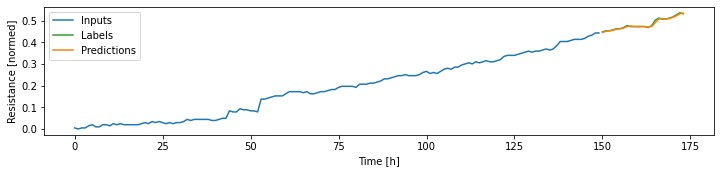

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)